# The Big Show
Using the open-source data provided by cricsheet.org, we can assess Glenn Maxwell’s impact on one of the world’s premier T20 competitions: the Big Bash. All data is correct as of 16th January 2021.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from highlight_text import htext
from PIL import Image
import requests
from io import BytesIO
import matplotlib.font_manager

matplotlib.font_manager._rebuild()
#matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [2]:
def reset_matplotlib():
    plt.rcParams.update(plt.rcParamsDefault)

The data from cricsheet is in the .yaml format. I have carried out the data preperation behind the scenes and important dataframes imported below as csv files. 
- bb being "ball-by-ball", as it sounds, including the on-striker batsman, bowler, the over and ball number, runs off the bat etc
- mi being "match information", including the team names playing in a fixture, dates, stadiums and scores etc.
- bbl_codes includes all the team names, their team name code and kit colours (useful for plotting later on)

In [3]:
bb = pd.read_csv('bb.csv')
mi = pd.read_csv('mi.csv').rename(columns={'Unnamed: 0':'id'})
bbl_codes = pd.read_csv('bbl_codes.csv')

We can create a bbl dictionary, this will be useful for linking Team Names to Colour Codes

In [4]:
bbl = bbl_codes.set_index('team_name').to_dict()

We can group the data by the Batsman's or Bowler's name to generate their career statistics in the BBL. Data spans all the way back to the 2010 competition.

In [11]:
batter = bb.groupby('Batsman', as_index=False).agg({'id':'count','Runs_off_bat':'sum','striker_out':'sum'
                                             ,'boundary':'sum','four':'sum','six':'sum'
                                                        # We take the team the player has faced the most death balls for
                                                        ,'team':lambda x:x.value_counts().index[0]})

# Renaming the columns just to have some uniformity
batter.columns = ['batter','balls','runs','out','boundary','four','six','team']

To make it easier to compare across players who have played varying amounts, we need to calculate the rate at which events occur. i.e. dividing the total numbers of events of a certain type by the number of balls a player has faced at the death. We do in this in a for loop to avoid repetitive code.

In [12]:
batter_rates = ['runs', 'out', 'boundary', 'four', 'six']
for col in batter_rates:
    batter[col+'_rate'] = batter[col] / batter['balls']

We need to set some overarching variables for the plots we are about to make.

In [13]:
title_font = "Alegreya Sans"
main_font = "Open Sans"
text_colour = 'w'

## Performance against different types of bowlers

We import a scrape of data from ESPNCricInfo. This has every bowlers' delivery type which will allow us to assess how the batters have fared at the death, split by Seam vs Spin.

In [14]:
bbl_bowlers = pd.read_csv('bbl_bowlers.csv')
bbl_bowlers.head()

,Bowler,Bowling Type,Bowling Group
0,A Flintoff,Right-arm fast-medium,Seam
1,A Zampa,Legbreak googly,Spin
2,AB McDonald,Right-arm fast-medium,Seam
3,AC Agar,Right-arm offbreak,Spin
4,AC McDermott,Right-arm fast-medium,Seam


We can now take the ball-by-ball data again, this time grouping a batter's performance by the type of bowling they are facing. This will help identify those batters that are more specialised against certain bowling types and those that thrive regardless of who they are facing.


An inner join will remove any balls where we don't have information on the bowler. This is a consequence of the provided scrape but we are only missing a handful of bowlers so the overarching trends won't be affected by small holes in the data.

In [15]:
batter_bowlingtype = bb.merge(bbl_bowlers, how='inner', on='Bowler'
                                 ).groupby(['Batsman','Bowling Group'], as_index=False
                                          ).agg({'id':'count','Runs_off_bat':'sum','striker_out':'sum'
                                             ,'boundary':'sum','four':'sum','six':'sum'
                                                        # We take the team the player has faced the most death balls for
                                                        ,'team':lambda x:x.value_counts().index[0]})

# Renaming the columns just to have some uniformity
batter_bowlingtype.columns = ['batter','bowling_type','balls','runs','out','boundary','four','six','team']

# We again filter down to minimise outliers, we will set a threshold of facing 2 overs against a bowling type
batter_bowlingtype_12 = batter_bowlingtype[batter_bowlingtype['balls'] > 100]

We again calculate the rates at which certain events happen

In [17]:
batter_rates = ['runs', 'out', 'boundary', 'four', 'six']
for col in batter_rates:
    batter_bowlingtype_12[col+'_rate'] = batter_bowlingtype_12[col] / batter_bowlingtype_12['balls']

<ipython-input-17-f7fb0a542fcd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batter_bowlingtype_12[col+'_rate'] = batter_bowlingtype_12[col] / batter_bowlingtype_12['balls']


We pivot on the bowling_type column to format the data into a manner which is easier for plotting.

In [18]:
batter_pivot = batter_bowlingtype_12.pivot(index=['batter','team'], columns='bowling_type'
                         , values=['runs_rate','out_rate','boundary_rate','four_rate','six_rate']).reset_index()

Renaming the columns removes the multi-level index which makes the dataframe easier and cleaner to manipulate.

In [19]:
pivot_cols = []
for col in batter_pivot.columns:
    if col[0] in ['batter','team']:
        pivot_cols.append(col[0])
    else:
        pivot_cols.append(col[1].lower()+'_'+col[0])

In [20]:
batter_pivot.columns = pivot_cols

We only want to compare players who have faced the requisite number of balls against both types of bowling.

In [21]:
batter_pivot.dropna(inplace=True)

We find the run rate at which Maxwell scores against spin and seam to use them in the plotting if statements

In [23]:
gmseam = batter_pivot[batter_pivot['batter'] == 'GJ Maxwell'].iloc[0]['seam_runs_rate']
gmspin = batter_pivot[batter_pivot['batter'] == 'GJ Maxwell'].iloc[0]['spin_runs_rate']

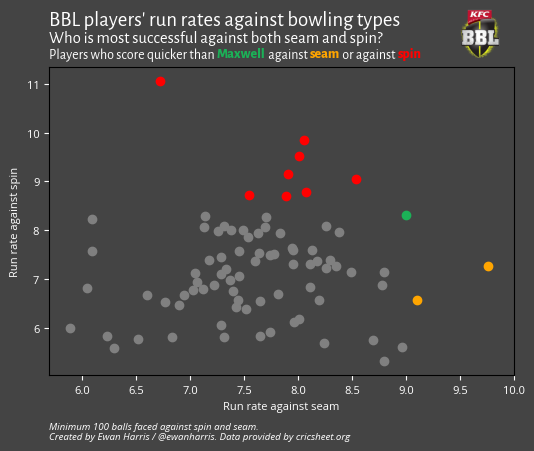

In [82]:
# reset_matplotlib()
fig, ax = plt.subplots(figsize=[6,4])

# Setting some plot properties
fig.set_facecolor('#444444')
ax.patch.set_facecolor('#444444')
plt.xticks(c=text_colour, fontfamily=main_font)
plt.yticks(c=text_colour, fontfamily=main_font)
ax.tick_params(axis='both', colors='white')

for batter in batter_pivot['batter'].tolist():
    _df = batter_pivot[batter_pivot['batter'] == batter].iloc[0]      
    
    if batter == 'GJ Maxwell':
        ax.scatter(_df['seam_runs_rate']*6, _df['spin_runs_rate']*6, c=bbl['team_colour_code'][_df['team']]
                   , zorder=2)
        
    elif _df['seam_runs_rate'] > gmseam:
        ax.scatter(_df['seam_runs_rate']*6, _df['spin_runs_rate']*6, c='orange'
                   , zorder=1)
        
    elif _df['spin_runs_rate'] > gmspin:
        ax.scatter(_df['seam_runs_rate']*6, _df['spin_runs_rate']*6, c='red'
                   , zorder=1)

    else:
        ax.scatter(_df['seam_runs_rate']*6, _df['spin_runs_rate']*6, c='grey',
                  zorder=1)
                
plt.xlim(right=10)

ax.set_ylabel('Run rate against spin', c=text_colour, fontfamily=main_font, fontsize=8)    
ax.set_xlabel('Run rate against seam', c=text_colour, fontfamily=main_font, fontsize=8)
plt.xticks(c=text_colour, fontfamily=main_font, fontsize=8)
plt.yticks(c=text_colour, fontfamily=main_font, fontsize=8)

htext.fig_text(x = 0.125, y = 0.975,
         s = "BBL players' run rates against bowling types",
         color = 'white', fontsize=15, fontfamily=title_font)

htext.fig_text(x = 0.125, y = 0.935,
         s = 'Who is most successful against both seam and spin?',
         color = 'white', fontsize=12, fontfamily=title_font)

htext.fig_text(x = 0.125, y = 0.895,
         s = 'Players who score quicker than <Maxwell> against <seam> or against <spin>',
         color = 'white', fontsize=10, fontfamily=title_font
              , highlight_colors = [bbl['team_colour_code']['Melbourne Stars'],'orange','red']
               ,highlight_weights=["bold"])

ax2 = fig.add_axes([0.78,0.9,0.125,0.125])
ax2.axis("off")
url = "C:/Users/Ewan/OneDrive/Python Projects/BBL/Big_Bash_League_(logo).png"
img = Image.open(url)
ax2.imshow(img)

fig.text(0.125, -0.05
         , "Minimum 100 balls faced against spin and seam.\nCreated by Ewan Harris / @ewanharris. Data provided by cricsheet.org",
        fontstyle="italic",fontsize=7, fontfamily=main_font, color=text_colour)
        
fig.savefig('seam_vs_spin.jpg', facecolor=fig.get_facecolor(), dpi=300, bbox_inches = 'tight')
plt.show()

We create a new aggregated dataframe using lambda val: (val==0).sum() on the Runs_off_bat column to count the number of times a player has faced a dot ball

In [25]:
dots = bb.groupby(['Batsman'], as_index=False
                                          ).agg({'id':'count','Runs_off_bat':['sum',lambda val: (val==0).sum()],'striker_out':'sum'
                                             ,'boundary':'sum','four':'sum','six':'sum'
                                                        # We take the team the player has faced the most death balls for
                                                        ,'team':lambda x:x.value_counts().index[0]}
                                               ).rename(columns={'Runs_off_bat':'dot_balls'})

# Renaming the columns just to have some uniformity
dots.columns = ['batter','balls','runs','dots','out','boundary','four','six','team']

In [26]:
batter_rates = ['runs', 'dots', 'out', 'boundary', 'four', 'six']
for col in batter_rates:
    dots[col+'_rate'] = dots[col] / dots['balls']

Adding in the limit that a player must haved faced at least 150 balls

In [27]:
dots = dots[dots['balls']>149]

In [28]:
dots.sort_values('dots_rate', inplace=True)
dots.reset_index(drop=True, inplace=True)

In [30]:
gm = dots[dots['batter'].isin(['GJ Maxwell','DJ Malan'])]

Combining the data of Maxwell and Malan with the top 8 dot rate players

In [88]:
dots_waffle = pd.concat([dots.iloc[0:8][['batter','dots_rate','team']],
                        gm[['batter','dots_rate','team']]])

How many dot balls and non-dot balls a player would face in 100 balls

In [91]:
dots_waffle['dots100'] = round(dots_waffle['dots_rate']*100,0)

In [92]:
dots_waffle

,batter,dots_rate,team,dots100,runs100
0,AC Voges,0.281170,Perth Scorchers,28.0,72.0
1,JC Silk,0.294951,Sydney Sixers,29.0,71.0
2,SPD Smith,0.296218,Sydney Sixers,30.0,70.0
3,PA Jaques,0.299435,Hobart Hurricanes,30.0,70.0
4,DA Miller,0.307190,Hobart Hurricanes,31.0,69.0
5,TK Curran,0.308036,Sydney Sixers,31.0,69.0
6,GJ Bailey,0.310287,Hobart Hurricanes,31.0,69.0
7,SW Billings,0.313099,Sydney Sixers,31.0,69.0
15,GJ Maxwell,0.329957,Melbourne Stars,33.0,67.0
97,DJ Malan,0.418750,Hobart Hurricanes,42.0,58.0


In [93]:
dots_waffle.head()

,batter,dots_rate,team,dots100,runs100
0,AC Voges,0.281170,Perth Scorchers,28.0,72.0
1,JC Silk,0.294951,Sydney Sixers,29.0,71.0
2,SPD Smith,0.296218,Sydney Sixers,30.0,70.0
3,PA Jaques,0.299435,Hobart Hurricanes,30.0,70.0
4,DA Miller,0.307190,Hobart Hurricanes,31.0,69.0


In [94]:
dots_waffle['c'] = dots_waffle['team'].apply(lambda x: bbl['team_colour_code'][x])

In [95]:
dot_rate_av = round(dots['dots_rate'].mean()*100,0)

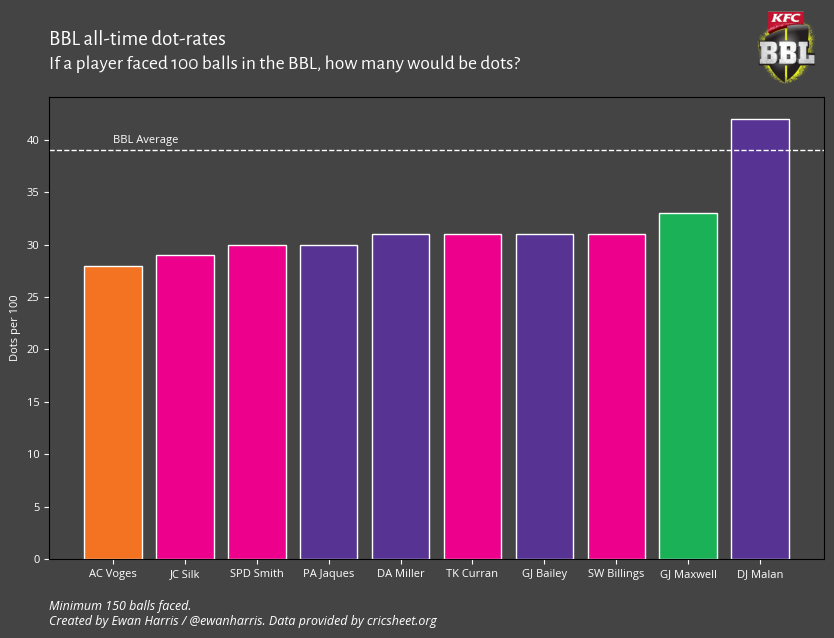

In [96]:
fig, ax = plt.subplots(figsize=(10,6))
fig.set_facecolor('#444444')
ax.patch.set_facecolor('#444444')
plt.xticks(c=text_colour, fontfamily=main_font, fontsize=8)
plt.yticks(c=text_colour, fontfamily=main_font, fontsize=8)
plt.ylabel('Dots per 100',c=text_colour, fontfamily=main_font, fontsize=8)
ax.tick_params(axis='both', colors='white')
plt.axhline(y=dot_rate_av,linewidth=1,linestyle='--',color=text_colour)
plt.text('AC Voges', dot_rate_av+0.75, s='BBL Average',c=text_colour, fontfamily=main_font, fontsize=8, ha='left')

plt.bar(dots_waffle['batter'],dots_waffle['dots100'], color=dots_waffle['c'], edgecolor='w')

#plt.subplots_adjust(hspace=0.5)
htext.fig_text(x = 0.125, y = 0.96,
         s = 'BBL all-time dot-rates',
         color = 'white', fontsize=15, fontfamily=title_font)
htext.fig_text(x = 0.125, y = 0.92,
         s = 'If a player faced 100 balls in the BBL, how many would be dots?',
         color = 'white', fontsize=14, fontfamily=title_font)
ax2 = fig.add_axes([0.8,0.9,0.125,0.125]) # badge
ax2.axis("off")
url = "C:/Users/Ewan/OneDrive/Python Projects/BBL/Big_Bash_League_(logo).png"
#response = requests.get(url)
img = Image.open(url)
ax2.imshow(img)

fig.text(0.125, 0, "Minimum 150 balls faced.\nCreated by Ewan Harris / @ewanharris. Data provided by cricsheet.org",
        fontstyle="italic",fontsize=9, fontfamily=main_font, color=text_colour)
fig.savefig('bar_dots_waffle_test.jpg', facecolor=fig.get_facecolor(), dpi=500, bbox_inches ='tight')
plt.show()

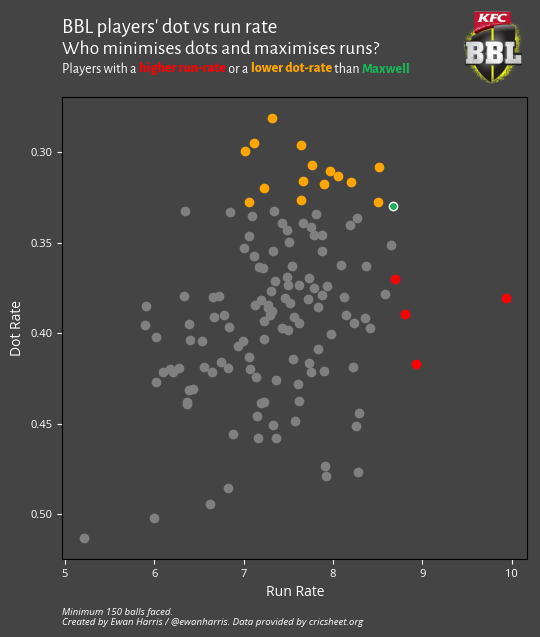

In [97]:
reset_matplotlib()

fig, ax = plt.subplots(figsize=(6,6))
fig.set_facecolor('#444444')
ax.patch.set_facecolor('#444444')

gmrr = dots[dots['batter']=='GJ Maxwell'].iloc[0]['runs_rate']
gmdr = dots[dots['batter']=='GJ Maxwell'].iloc[0]['dots_rate']

for batter in dots['batter'].tolist():
    _df = dots[dots['batter'] == batter].iloc[0]
    
    if _df['runs_rate'] > gmrr:
        ax.scatter(_df['runs_rate']*6,_df['dots_rate'], c='red'
          , zorder=1)
        
    elif _df['dots_rate'] < gmdr:
        ax.scatter(_df['runs_rate']*6,_df['dots_rate'], c='orange'
          , zorder=1)
    
    elif batter == 'GJ Maxwell':
        ax.scatter(_df['runs_rate']*6,_df['dots_rate'], c=bbl['team_colour_code'][_df['team']]
          , zorder=2, edgecolors=text_colour)
        
    else:
        ax.scatter(_df['runs_rate']*6,_df['dots_rate'], c='grey'
          , zorder=1)
        
plt.xticks(c=text_colour, fontfamily=main_font, fontsize=8)
plt.yticks(c=text_colour, fontfamily=main_font, fontsize=8)
ax.set_xlabel('Run Rate', c=text_colour, fontfamily=main_font)
ax.set_ylabel('Dot Rate', c=text_colour, fontfamily=main_font)
ax.tick_params(axis='both', colors=text_colour)
ax.invert_yaxis()

htext.fig_text(x = 0.125, y = 0.98,
         s = "BBL players' dot vs run rate",
         color = 'white', fontsize=15, fontfamily=title_font)
htext.fig_text(x = 0.125, y = 0.945,
         s = 'Who minimises dots and maximises runs?',
         color = 'white', fontsize=14, fontfamily=title_font)

htext.fig_text(x = 0.125, y = 0.915,
         s = 'Players with a <higher run-rate> or a <lower dot-rate> than <Maxwell>',
         color = 'white', fontsize=10, fontfamily=title_font
              , highlight_colors = ['red','orange',bbl['team_colour_code']['Melbourne Stars']],highlight_weights=["bold"])

ax2 = fig.add_axes([0.78,0.9,0.125,0.125]) # badge
ax2.axis("off")
url = "C:/Users/Ewan/OneDrive/Python Projects/BBL/Big_Bash_League_(logo).png"
#response = requests.get(url)
img = Image.open(url)
ax2.imshow(img)

fig.text(0.125, 0, "Minimum 150 balls faced.\nCreated by Ewan Harris / @ewanharris. Data provided by cricsheet.org",
        fontstyle="italic",fontsize=7, fontfamily=main_font, color=text_colour)

fig.savefig('dots_vs_runs.jpg', facecolor=fig.get_facecolor(), dpi=500, bbox_inches ='tight')

plt.show()

In [98]:
by_team = bb.groupby(['Batsman','team','id'], as_index=False).size().groupby('Batsman', as_index=False).agg({'team':lambda x: x.value_counts().to_dict(), 'id':'count'}).sort_values('id', ascending=False)

In [99]:
by_team['team_counts'] = by_team['team'].apply(lambda x: list(np.cumsum(list(x.values()))))
by_team['team_names'] = by_team['team'].apply(lambda x: list(x.keys()))

In [100]:
max_number = math.ceil(math.sqrt(by_team['id'].max()))

In [101]:
rr = bb.groupby(['Batsman','Over'], as_index=False).agg({'id':'count','Runs_off_bat':['sum',lambda val: (val==0).sum()],'striker_out':'sum'
                                             ,'boundary':'sum','four':'sum','six':'sum'
                                                        # We take the team the player has faced the most death balls for
                                                        ,'team':lambda x:x.value_counts().index[0]}
                                               )

# Renaming the columns just to have some uniformity
rr.columns = ['batter','over','balls','runs','dots','out','boundary','four','six','team']

In [103]:
batter_rates = ['runs', 'dots', 'out', 'boundary', 'four', 'six']
for col in batter_rates:
    rr[col+'_rate'] = rr[col] / rr['balls']

Users must have faced at least 3 balls in any given over number

In [108]:
rr = rr[rr['balls']>2]

In [109]:
rr.sort_values('runs_rate')

,batter,over,balls,runs,dots,out,boundary,four,six,team,runs_rate,dots_rate,out_rate,boundary_rate,four_rate,six_rate
3538,RR Rossouw,3,3,0,3,1.0,0,0,0,Melbourne Renegades,0.000000,1.000000,0.333333,0.000000,0.000000,0.000000
1024,CP Tremain,14,3,0,3,0.0,0,0,0,Sydney Thunder,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
1082,DA Miller,2,3,0,3,1.0,0,0,0,Hobart Hurricanes,0.000000,1.000000,0.333333,0.000000,0.000000,0.000000
3938,Shakib Al Hasan,19,3,0,3,1.0,0,0,0,Melbourne Renegades,0.000000,1.000000,0.333333,0.000000,0.000000,0.000000
3034,Mohammad Nabi,4,3,0,3,0.0,0,0,0,Melbourne Renegades,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,BJ Holt,14,5,19,0,0.0,3,1,2,Sydney Thunder,3.800000,0.000000,0.000000,0.600000,0.200000,0.400000
2259,JW Hastings,10,4,16,1,0.0,3,1,2,Melbourne Stars,4.000000,0.250000,0.000000,0.750000,0.250000,0.500000
3172,NLTC Perera,13,3,12,1,0.0,2,0,2,Brisbane Heat,4.000000,0.333333,0.000000,0.666667,0.000000,0.666667
723,C Munro,16,3,13,0,0.0,2,0,2,Perth Scorchers,4.333333,0.000000,0.000000,0.666667,0.000000,0.666667


In [110]:
av_rr = rr[rr['batter']!=('GJ Maxwell')].groupby('over',as_index=False).agg({'balls':'sum','runs':'sum'})
av_rr['runs_rate'] = av_rr['runs'] / av_rr['balls']

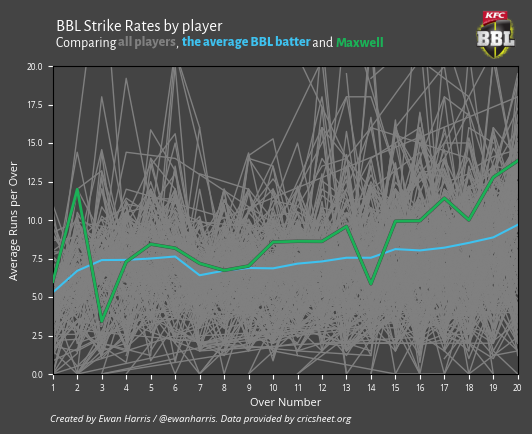

In [111]:
reset_matplotlib()

highlight = 'GJ Maxwell'

fig,ax = plt.subplots(figsize=[6,4])

fig.set_facecolor('#444444')
ax.patch.set_facecolor('#444444')

plt.xticks(c=text_colour, fontfamily=main_font, fontsize=6)
plt.yticks(c=text_colour, fontfamily=main_font, fontsize=6)
ax.tick_params(axis='both', colors=text_colour)

for batter in rr['batter'].unique():
    _df = rr[rr['batter']==batter]
    c='grey'
    z=1
    lw=1
    if batter == highlight:
        c = bbl['team_colour_code'][_df['team'].iloc[0]]
        z=3
        lw=2
        ax.plot(_df['over'],_df['runs_rate']*6, c='#444444', zorder=z-0.5, linewidth=lw+0.5)
    
    ax.plot(_df['over'],_df['runs_rate']*6, c=c, zorder=z, linewidth=lw)
    ax.set_xticks(range(0,21))
    
ax.plot(av_rr['over'],av_rr['runs_rate']*6, zorder=2, c='#3EC2F0')
    
htext.fig_text(x = 0.13, y = 0.96,
         s = 'BBL Strike Rates by player',
         color = 'white', fontsize=12, fontfamily=title_font)

htext.fig_text(x = 0.13, y = 0.92,
         s = "Comparing <all players>, <the average BBL batter> and <Maxwell>",
         color = 'white', fontsize=10, fontfamily=title_font
               , highlight_colors = ['grey','#3EC2F0',bbl['team_colour_code']['Melbourne Stars']]
               ,highlight_weights=["bold"])

ax2 = fig.add_axes([0.8,0.895,0.125,0.125]) # badge
ax2.axis("off")
url = "C:/Users/Ewan/OneDrive/Python Projects/BBL/Big_Bash_League_(logo).png"
#response = requests.get(url)
img = Image.open(url)
ax2.imshow(img)

fig.text(0.12, -0.01, "Created by Ewan Harris / @ewanharris. Data provided by cricsheet.org",
        fontstyle="italic",fontsize=7, fontfamily=main_font, color=text_colour)

ax.set_ylabel('Average Runs per Over', c=text_colour, fontfamily=main_font, fontsize=8)    
ax.set_xlabel('Over Number', c=text_colour, fontfamily=main_font, fontsize=8)
# plt.title(f"{highlight}'s career BBL run-rate through the innings", c=text_colour
#           , fontfamily=title_font, fontsize=10)
ax.set_xlim([1,20])   
ax.set_ylim([0,20])
fig.savefig('strike_rate_by_over.jpg', facecolor=fig.get_facecolor(), dpi=500, bbox_inches ='tight')
plt.show()

In [112]:
by_team = bb.groupby(['Batsman','team','id'], as_index=False).size().groupby('Batsman', as_index=False).agg({'team':lambda x: x.value_counts().to_dict(), 'id':'count'}).sort_values('id', ascending=False)

As cricsheet don't provide full team sheets, an appearance is defined as a name that appears as the on strike batsman, the non-striker batsman or as a bowler.

In [113]:
cols = ['name','team','id','count']

bat = pd.DataFrame(bb.groupby(['Batsman','team','id'], as_index=False).size())
bat.columns = cols
stri = pd.DataFrame(bb.groupby(['Non_striker','team','id'], as_index=False).size())
stri.columns = cols
bow = pd.DataFrame(bb.groupby(['Bowler','field_team','id'], as_index=False).size())
bow.columns = cols

In [114]:
appearances = pd.concat([bat,stri,bow]).drop(columns=['count']).sort_values('name')

If a player appears as a striker and non-striker in the same game, we don't want to count the appearance twice.

In [115]:
appearances.drop_duplicates(inplace=True)

In [116]:
app = appearances.groupby('name', as_index=False).agg({'team':lambda x: x.value_counts().to_dict(), 'id':pd.Series.nunique}).sort_values('id', ascending=False)

In [117]:
app['team_counts'] = app['team'].apply(lambda x: list(np.cumsum(list(x.values()))))
app['team_names'] = app['team'].apply(lambda x: list(x.keys()))

In [118]:
app.head(15)

,name,team,id,team_counts,team_names
119,DT Christian,"{'Melbourne Renegades': 30, 'Hobart Hurricanes...",94,"[30, 58, 84, 94]","[Melbourne Renegades, Hobart Hurricanes, Brisb..."
44,BCJ Cutting,"{'Brisbane Heat': 78, 'Sydney Thunder': 10}",88,"[78, 88]","[Brisbane Heat, Sydney Thunder]"
36,B Laughlin,"{'Adelaide Strikers': 49, 'Hobart Hurricanes':...",84,"[49, 68, 84]","[Adelaide Strikers, Hobart Hurricanes, Brisban..."
283,NJ Maddinson,"{'Sydney Sixers': 54, 'Melbourne Stars': 27}",81,"[54, 81]","[Sydney Sixers, Melbourne Stars]"
205,JW Wells,"{'Adelaide Strikers': 49, 'Hobart Hurricanes':...",81,"[49, 81]","[Adelaide Strikers, Hobart Hurricanes]"
66,CA Lynn,{'Brisbane Heat': 79},79,[79],[Brisbane Heat]
134,GJ Maxwell,"{'Melbourne Stars': 73, 'Melbourne Renegades': 5}",78,"[73, 78]","[Melbourne Stars, Melbourne Renegades]"
57,BR Dunk,"{'Melbourne Stars': 39, 'Hobart Hurricanes': 2...",77,"[39, 63, 71, 77]","[Melbourne Stars, Hobart Hurricanes, Adelaide ..."
242,MC Henriques,{'Sydney Sixers': 76},76,[76],[Sydney Sixers]
76,CJ Ferguson,"{'Sydney Thunder': 47, 'Melbourne Renegades': ...",75,"[47, 62, 75]","[Sydney Thunder, Melbourne Renegades, Adelaide..."


In [119]:
max_number = math.ceil(math.sqrt(app['id'].max()))

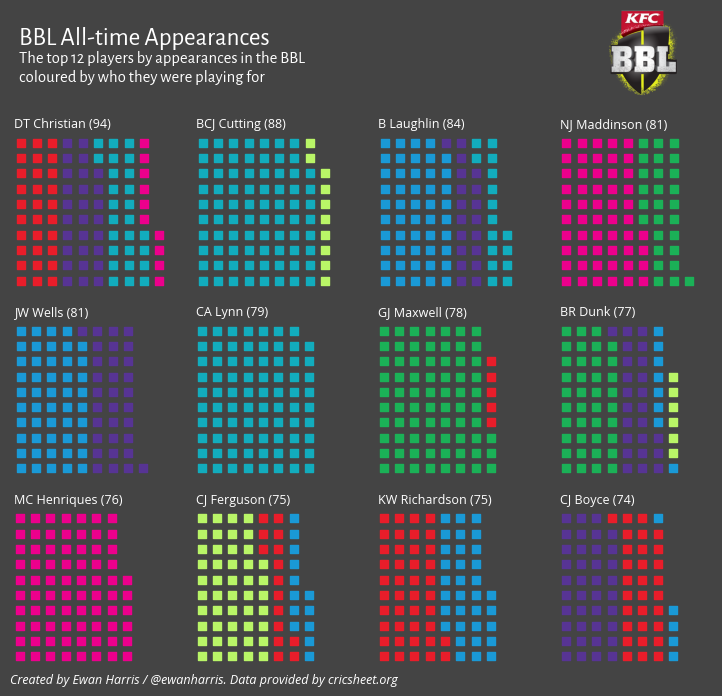

In [120]:
reset_matplotlib()
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(9,7))

fig.set_facecolor('#444444')

counter = 0

for i in range(0,3):
    for j in range(0,4):
        _df = app.iloc[counter]
        bat = _df['name']
        games = _df['id']
        a = ax[i,j]
        n = 1
        for x in range(1,max_number+1):
            for y in range(1,max_number+1):
                if n > _df['id']:
                    break                
                for ids in _df['team_counts']:
                    #print(ids)
                    if n <= ids:
                        team_id = _df['team_counts'].index(ids)
                        team = _df['team_names'][team_id]
                        colour = bbl['team_colour_code'][team]
                        break
                n+=1
                a.scatter(x,y,marker='s',c=colour)
                a.set_title(f'{bat} ({games})', c=text_colour, fontsize=9, loc='left', fontfamily=main_font)
                
        a.axis('square')
        a.axis('off')
        counter +=1 
        
plt.subplots_adjust(hspace=0.15)
htext.fig_text(x = 0.13, y = 0.995,
         s = 'BBL All-time Appearances',
         color = 'white', fontsize=18, fontfamily=title_font)

htext.fig_text(x = 0.13, y = 0.945,
         s = 'The top 12 players by appearances in the BBL \ncoloured by who they were playing for',
         color = 'white', fontsize=12, fontfamily=title_font)

ax2 = fig.add_axes([0.76,0.9275,0.125,0.125]) # badge
ax2.axis("off")
url = "C:/Users/Ewan/OneDrive/Python Projects/BBL/Big_Bash_League_(logo).png"
img = Image.open(url)
ax2.imshow(img)

fig.text(0.12, 0.09, "Created by Ewan Harris / @ewanharris. Data provided by cricsheet.org",
        fontstyle="italic",fontsize=9, fontfamily=main_font, color=text_colour)

fig.savefig('appearances_waffle.jpg', facecolor=fig.get_facecolor(), dpi=500, bbox_inches ='tight')
plt.show()